## Using Keras to Build and Train Neural Networks

In [1]:
from __future__ import absolute_import, division, print_function  # Python 2/3 compatibility
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_auc_score, roc_curve, accuracy_score
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
%matplotlib inline

In [3]:
from keras.models  import Sequential
from keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization
from keras.optimizers import Adam, SGD, RMSprop

In [6]:
names = ["times_pregnant", "glucose_tolerance_test", "blood_pressure", "skin_thickness", "insulin", 
         "bmi", "pedigree_function", "age", "has_diabetes"]
diabetes_df = pd.read_csv('datasets_14370_19291_pima-indians-diabetes.csv', names=names)

In [28]:
diabetes_df.corr()

,times_pregnant,glucose_tolerance_test,blood_pressure,skin_thickness,insulin,bmi,pedigree_function,age,has_diabetes
times_pregnant,1.000000,0.129459,0.141282,-0.081672,-0.073535,0.017683,-0.033523,0.544341,0.221898
glucose_tolerance_test,0.129459,1.000000,0.152590,0.057328,0.331357,0.221071,0.137337,0.263514,0.466581
blood_pressure,0.141282,0.152590,1.000000,0.207371,0.088933,0.281805,0.041265,0.239528,0.065068
skin_thickness,-0.081672,0.057328,0.207371,1.000000,0.436783,0.392573,0.183928,-0.113970,0.074752
insulin,-0.073535,0.331357,0.088933,0.436783,1.000000,0.197859,0.185071,-0.042163,0.130548
bmi,0.017683,0.221071,0.281805,0.392573,0.197859,1.000000,0.140647,0.036242,0.292695
pedigree_function,-0.033523,0.137337,0.041265,0.183928,0.185071,0.140647,1.000000,0.033561,0.173844
age,0.544341,0.263514,0.239528,-0.113970,-0.042163,0.036242,0.033561,1.000000,0.238356
has_diabetes,0.221898,0.466581,0.065068,0.074752,0.130548,0.292695,0.173844,0.238356,1.000000


In [7]:
print(diabetes_df.shape)
diabetes_df.sample(5)

(768, 9)


,times_pregnant,glucose_tolerance_test,blood_pressure,skin_thickness,insulin,bmi,pedigree_function,age,has_diabetes
364,4,147,74,25,293,34.9,0.385,30,0
581,6,109,60,27,0,25.0,0.206,27,0
396,3,96,56,34,115,24.7,0.944,39,0
360,5,189,64,33,325,31.2,0.583,29,1
387,8,105,100,36,0,43.3,0.239,45,1


In [8]:
X = diabetes_df.iloc[:, :-1].values
y = diabetes_df["has_diabetes"].values

In [9]:
# Split the data to Train, and Test (75%, 25%)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=11111)

In [10]:
np.mean(y), np.mean(1-y)

(0.3489583333333333, 0.6510416666666666)

In [11]:
## Train the RF Model
rf_model = RandomForestClassifier(n_estimators=200)
rf_model.fit(X_train, y_train)

RandomForestClassifier(n_estimators=200)

In [12]:
# Make predictions on the test set - both "hard" predictions, and the scores (percent of trees voting yes)
y_pred_class_rf = rf_model.predict(X_test)
y_pred_prob_rf = rf_model.predict_proba(X_test)


print('accuracy is {:.3f}'.format(accuracy_score(y_test,y_pred_class_rf)))
print('roc-auc is {:.3f}'.format(roc_auc_score(y_test,y_pred_prob_rf[:,1])))

accuracy is 0.766
roc-auc is 0.826


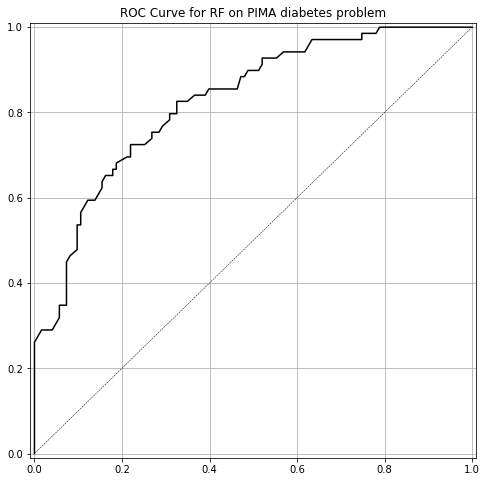

In [13]:
def plot_roc(y_test, y_pred, model_name):
    fpr, tpr, thr = roc_curve(y_test, y_pred)
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.plot(fpr, tpr, 'k-')
    ax.plot([0, 1], [0, 1], 'k--', linewidth=.5)  # roc curve for random model
    ax.grid(True)
    ax.set(title='ROC Curve for {} on PIMA diabetes problem'.format(model_name),
           xlim=[-0.01, 1.01], ylim=[-0.01, 1.01])


plot_roc(y_test, y_pred_prob_rf[:, 1], 'RF')

## Build a Single Hidden Layer Neural Network

We will use the Sequential model to quickly build a neural network.  Our first network will be a single layer network.  We have 8 variables, so we set the input shape to 8.  Let's start by having a single hidden layer with 12 nodes.

In [14]:
normalizer = StandardScaler()
X_train_norm = normalizer.fit_transform(X_train)
X_test_norm = normalizer.transform(X_test)

In [15]:
# Define the Model 
# Input size is 8-dimensional
# 1 hidden layer, 12 hidden nodes, sigmoid activation
# Final layer has just one node with a sigmoid activation (standard for binary classification)

model_1 = Sequential([
    Dense(12, input_shape=(8,), activation="relu"),
    Dense(1, activation="sigmoid")
])

In [16]:
model_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 12)                108       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 13        
Total params: 121
Trainable params: 121
Non-trainable params: 0
_________________________________________________________________


In [17]:
model_1.compile(GD(lr = .003), "binary_crossentropy", metrics=["accuracy"])
run_hist_1 = model_1.fit(X_train_norm, y_train, validation_data=(X_test_norm, y_test), epochs=200)

Epoch 1/200
18/18 [==============================] - 1s 37ms/step - loss: 0.6822 - accuracy: 0.5972 - val_loss: 0.6805 - val_accuracy: 0.5885
Epoch 2/200
18/18 [==============================] - 0s 8ms/step - loss: 0.6760 - accuracy: 0.6024 - val_loss: 0.6750 - val_accuracy: 0.5990
Epoch 3/200
18/18 [==============================] - 0s 8ms/step - loss: 0.6700 - accuracy: 0.6094 - val_loss: 0.6697 - val_accuracy: 0.6042
Epoch 4/200
18/18 [==============================] - 0s 8ms/step - loss: 0.6643 - accuracy: 0.6128 - val_loss: 0.6647 - val_accuracy: 0.6042
Epoch 5/200
18/18 [==============================] - 0s 8ms/step - loss: 0.6588 - accuracy: 0.6285 - val_loss: 0.6598 - val_accuracy: 0.6198
Epoch 6/200
18/18 [==============================] - 0s 8ms/step - loss: 0.6535 - accuracy: 0.6372 - val_loss: 0.6552 - val_accuracy: 0.6302
Epoch 7/200
18/18 [==============================] - 0s 8ms/step - loss: 0.6484 - accuracy: 0.6406 - val_loss: 0.6507 - val_accuracy: 0.6302
Epoch 8/200


Epoch 59/200
18/18 [==============================] - 0s 8ms/step - loss: 0.5185 - accuracy: 0.7431 - val_loss: 0.5408 - val_accuracy: 0.7344
Epoch 60/200
18/18 [==============================] - 0s 8ms/step - loss: 0.5173 - accuracy: 0.7483 - val_loss: 0.5399 - val_accuracy: 0.7344
Epoch 61/200
18/18 [==============================] - 0s 8ms/step - loss: 0.5161 - accuracy: 0.7500 - val_loss: 0.5390 - val_accuracy: 0.7344
Epoch 62/200
18/18 [==============================] - 0s 10ms/step - loss: 0.5149 - accuracy: 0.7500 - val_loss: 0.5381 - val_accuracy: 0.7344
Epoch 63/200
18/18 [==============================] - 0s 8ms/step - loss: 0.5137 - accuracy: 0.7483 - val_loss: 0.5373 - val_accuracy: 0.7344
Epoch 64/200
18/18 [==============================] - 0s 8ms/step - loss: 0.5126 - accuracy: 0.7483 - val_loss: 0.5365 - val_accuracy: 0.7344
Epoch 65/200
18/18 [==============================] - 0s 7ms/step - loss: 0.5115 - accuracy: 0.7483 - val_loss: 0.5356 - val_accuracy: 0.7344
Epoch

18/18 [==============================] - 0s 8ms/step - loss: 0.4552 - accuracy: 0.7760 - val_loss: 0.5018 - val_accuracy: 0.7708
Epoch 174/200
18/18 [==============================] - 0s 9ms/step - loss: 0.4550 - accuracy: 0.7760 - val_loss: 0.5017 - val_accuracy: 0.7708
Epoch 175/200
18/18 [==============================] - 0s 8ms/step - loss: 0.4549 - accuracy: 0.7760 - val_loss: 0.5016 - val_accuracy: 0.7708
Epoch 176/200
18/18 [==============================] - 0s 7ms/step - loss: 0.4546 - accuracy: 0.7760 - val_loss: 0.5016 - val_accuracy: 0.7708
Epoch 177/200
18/18 [==============================] - 0s 8ms/step - loss: 0.4544 - accuracy: 0.7760 - val_loss: 0.5015 - val_accuracy: 0.7708
Epoch 178/200
18/18 [==============================] - 0s 7ms/step - loss: 0.4543 - accuracy: 0.7760 - val_loss: 0.5014 - val_accuracy: 0.7708
Epoch 179/200
18/18 [==============================] - 0s 7ms/step - loss: 0.4540 - accuracy: 0.7760 - val_loss: 0.5014 - val_accuracy: 0.7708
Epoch 180/200

In [18]:
## Like we did for the Random Forest, we generate two kinds of predictions
#  One is a hard decision, the other is a probabilitistic score.

y_pred_class_nn_1 = model_1.predict_classes(X_test_norm)
y_pred_prob_nn_1 = model_1.predict(X_test_norm)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


In [19]:
# Let's check out the outputs to get a feel for how keras apis work.
y_pred_class_nn_1[:10]

array([[0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0]])

In [20]:
y_pred_prob_nn_1[:10]

array([[0.41535407],
       [0.6633033 ],
       [0.3244111 ],
       [0.21368268],
       [0.1987974 ],
       [0.4981894 ],
       [0.08118996],
       [0.31475806],
       [0.86975056],
       [0.17624307]], dtype=float32)

accuracy is 0.771
roc-auc is 0.813


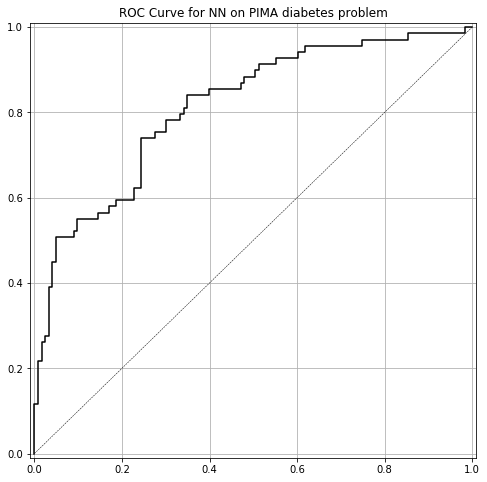

In [21]:
# Print model performance and plot the roc curve
print('accuracy is {:.3f}'.format(accuracy_score(y_test,y_pred_class_nn_1)))
print('roc-auc is {:.3f}'.format(roc_auc_score(y_test,y_pred_prob_nn_1)))

plot_roc(y_test, y_pred_prob_nn_1, 'NN')

There may be some variation in exact numbers due to randomness, but you should get results in the same ballpark as the Random Forest - between 75% and 85% accuracy, between .8 and .9 for AUC.

Let's look at the `run_hist_1` object that was created, specifically its `history` attribute.

In [22]:
run_hist_1.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

Let's plot the training loss and the validation loss over the different epochs and see how it looks.

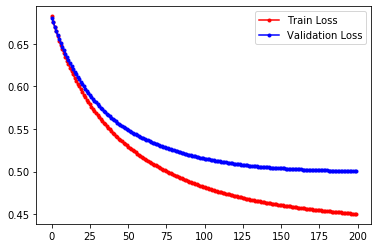

In [23]:
fig, ax = plt.subplots()
ax.plot(run_hist_1.history["loss"],'r', marker='.', label="Train Loss")
ax.plot(run_hist_1.history["val_loss"],'b', marker='.', label="Validation Loss")
ax.legend()

Looks like the losses are still going down on both the training set and the validation set.  This suggests that the model might benefit from further training.  Let's train the model a little more and see what happens. Note that it will pick up from where it left off. Train for 1000 more epochs.

In [24]:
## Note that when we call "fit" again, it picks up where it left off
run_hist_1b = model_1.fit(X_train_norm, y_train, validation_data=(X_test_norm, y_test), epochs=1000)

Epoch 1/1000
18/18 [==============================] - 0s 17ms/step - loss: 0.4501 - accuracy: 0.7795 - val_loss: 0.5004 - val_accuracy: 0.7708
Epoch 2/1000
18/18 [==============================] - 0s 8ms/step - loss: 0.4500 - accuracy: 0.7778 - val_loss: 0.5004 - val_accuracy: 0.7708
Epoch 3/1000
18/18 [==============================] - 0s 8ms/step - loss: 0.4499 - accuracy: 0.7812 - val_loss: 0.5004 - val_accuracy: 0.7708
Epoch 4/1000
18/18 [==============================] - 0s 8ms/step - loss: 0.4497 - accuracy: 0.7812 - val_loss: 0.5003 - val_accuracy: 0.7708
Epoch 5/1000
18/18 [==============================] - 0s 11ms/step - loss: 0.4495 - accuracy: 0.7812 - val_loss: 0.5003 - val_accuracy: 0.7708
Epoch 6/1000
18/18 [==============================] - 0s 8ms/step - loss: 0.4494 - accuracy: 0.7830 - val_loss: 0.5003 - val_accuracy: 0.7708
Epoch 7/1000
18/18 [==============================] - 0s 8ms/step - loss: 0.4492 - accuracy: 0.7812 - val_loss: 0.5002 - val_accuracy: 0.7708
Epoc

18/18 [==============================] - 0s 8ms/step - loss: 0.4385 - accuracy: 0.7812 - val_loss: 0.5012 - val_accuracy: 0.7604
Epoch 116/1000
18/18 [==============================] - 0s 9ms/step - loss: 0.4384 - accuracy: 0.7812 - val_loss: 0.5013 - val_accuracy: 0.7604
Epoch 117/1000
18/18 [==============================] - 0s 9ms/step - loss: 0.4384 - accuracy: 0.7812 - val_loss: 0.5013 - val_accuracy: 0.7604
Epoch 118/1000
18/18 [==============================] - 0s 8ms/step - loss: 0.4383 - accuracy: 0.7812 - val_loss: 0.5013 - val_accuracy: 0.7604
Epoch 119/1000
18/18 [==============================] - 0s 7ms/step - loss: 0.4382 - accuracy: 0.7812 - val_loss: 0.5013 - val_accuracy: 0.7604
Epoch 120/1000
18/18 [==============================] - 0s 7ms/step - loss: 0.4382 - accuracy: 0.7812 - val_loss: 0.5013 - val_accuracy: 0.7604
Epoch 121/1000
18/18 [==============================] - 0s 7ms/step - loss: 0.4381 - accuracy: 0.7812 - val_loss: 0.5014 - val_accuracy: 0.7604
Epoch 1

Epoch 172/1000
18/18 [==============================] - 0s 8ms/step - loss: 0.4351 - accuracy: 0.7795 - val_loss: 0.5028 - val_accuracy: 0.7552
Epoch 173/1000
18/18 [==============================] - 0s 8ms/step - loss: 0.4350 - accuracy: 0.7795 - val_loss: 0.5028 - val_accuracy: 0.7552
Epoch 174/1000
18/18 [==============================] - 0s 7ms/step - loss: 0.4349 - accuracy: 0.7795 - val_loss: 0.5028 - val_accuracy: 0.7552
Epoch 175/1000
18/18 [==============================] - 0s 8ms/step - loss: 0.4349 - accuracy: 0.7795 - val_loss: 0.5029 - val_accuracy: 0.7552
Epoch 176/1000
18/18 [==============================] - 0s 7ms/step - loss: 0.4348 - accuracy: 0.7795 - val_loss: 0.5029 - val_accuracy: 0.7552
Epoch 177/1000
18/18 [==============================] - 0s 7ms/step - loss: 0.4348 - accuracy: 0.7795 - val_loss: 0.5029 - val_accuracy: 0.7552
Epoch 178/1000
18/18 [==============================] - 0s 8ms/step - loss: 0.4347 - accuracy: 0.7795 - val_loss: 0.5030 - val_accuracy:

Epoch 285/1000
18/18 [==============================] - 0s 7ms/step - loss: 0.4301 - accuracy: 0.7795 - val_loss: 0.5061 - val_accuracy: 0.7656
Epoch 286/1000
18/18 [==============================] - 0s 9ms/step - loss: 0.4301 - accuracy: 0.7795 - val_loss: 0.5061 - val_accuracy: 0.7656
Epoch 287/1000
18/18 [==============================] - 0s 8ms/step - loss: 0.4301 - accuracy: 0.7795 - val_loss: 0.5061 - val_accuracy: 0.7656
Epoch 288/1000
18/18 [==============================] - 0s 7ms/step - loss: 0.4300 - accuracy: 0.7795 - val_loss: 0.5061 - val_accuracy: 0.7656
Epoch 289/1000
18/18 [==============================] - 0s 8ms/step - loss: 0.4300 - accuracy: 0.7795 - val_loss: 0.5062 - val_accuracy: 0.7656
Epoch 290/1000
18/18 [==============================] - 0s 8ms/step - loss: 0.4300 - accuracy: 0.7795 - val_loss: 0.5062 - val_accuracy: 0.7656
Epoch 291/1000
18/18 [==============================] - 0s 9ms/step - loss: 0.4299 - accuracy: 0.7795 - val_loss: 0.5062 - val_accuracy:

Epoch 342/1000
18/18 [==============================] - 0s 9ms/step - loss: 0.4281 - accuracy: 0.7795 - val_loss: 0.5075 - val_accuracy: 0.7656
Epoch 343/1000
18/18 [==============================] - 0s 8ms/step - loss: 0.4281 - accuracy: 0.7795 - val_loss: 0.5075 - val_accuracy: 0.7656
Epoch 344/1000
18/18 [==============================] - 0s 8ms/step - loss: 0.4281 - accuracy: 0.7795 - val_loss: 0.5076 - val_accuracy: 0.7656
Epoch 345/1000
18/18 [==============================] - 0s 10ms/step - loss: 0.4281 - accuracy: 0.7795 - val_loss: 0.5076 - val_accuracy: 0.7656
Epoch 346/1000
18/18 [==============================] - 0s 11ms/step - loss: 0.4280 - accuracy: 0.7812 - val_loss: 0.5076 - val_accuracy: 0.7656
Epoch 347/1000
18/18 [==============================] - 0s 9ms/step - loss: 0.4280 - accuracy: 0.7795 - val_loss: 0.5076 - val_accuracy: 0.7656
Epoch 348/1000
18/18 [==============================] - 0s 14ms/step - loss: 0.4280 - accuracy: 0.7795 - val_loss: 0.5077 - val_accura

Epoch 399/1000
18/18 [==============================] - 0s 8ms/step - loss: 0.4263 - accuracy: 0.7830 - val_loss: 0.5091 - val_accuracy: 0.7656
Epoch 400/1000
18/18 [==============================] - 0s 8ms/step - loss: 0.4263 - accuracy: 0.7830 - val_loss: 0.5091 - val_accuracy: 0.7656
Epoch 401/1000
18/18 [==============================] - 0s 8ms/step - loss: 0.4262 - accuracy: 0.7830 - val_loss: 0.5091 - val_accuracy: 0.7656
Epoch 402/1000
18/18 [==============================] - 0s 9ms/step - loss: 0.4262 - accuracy: 0.7830 - val_loss: 0.5091 - val_accuracy: 0.7656
Epoch 403/1000
18/18 [==============================] - 0s 9ms/step - loss: 0.4262 - accuracy: 0.7830 - val_loss: 0.5092 - val_accuracy: 0.7604
Epoch 404/1000
18/18 [==============================] - 0s 8ms/step - loss: 0.4261 - accuracy: 0.7830 - val_loss: 0.5092 - val_accuracy: 0.7604
Epoch 405/1000
18/18 [==============================] - 0s 8ms/step - loss: 0.4261 - accuracy: 0.7812 - val_loss: 0.5092 - val_accuracy:

Epoch 512/1000
18/18 [==============================] - 0s 8ms/step - loss: 0.4231 - accuracy: 0.7865 - val_loss: 0.5121 - val_accuracy: 0.7552
Epoch 513/1000
18/18 [==============================] - 0s 7ms/step - loss: 0.4231 - accuracy: 0.7865 - val_loss: 0.5121 - val_accuracy: 0.7552
Epoch 514/1000
18/18 [==============================] - 0s 8ms/step - loss: 0.4230 - accuracy: 0.7847 - val_loss: 0.5121 - val_accuracy: 0.7552
Epoch 515/1000
18/18 [==============================] - 0s 8ms/step - loss: 0.4230 - accuracy: 0.7882 - val_loss: 0.5121 - val_accuracy: 0.7552
Epoch 516/1000
18/18 [==============================] - 0s 8ms/step - loss: 0.4230 - accuracy: 0.7882 - val_loss: 0.5122 - val_accuracy: 0.7552
Epoch 517/1000
18/18 [==============================] - 0s 8ms/step - loss: 0.4230 - accuracy: 0.7882 - val_loss: 0.5122 - val_accuracy: 0.7552
Epoch 518/1000
18/18 [==============================] - 0s 9ms/step - loss: 0.4230 - accuracy: 0.7865 - val_loss: 0.5122 - val_accuracy:

Epoch 569/1000
18/18 [==============================] - 0s 8ms/step - loss: 0.4218 - accuracy: 0.7934 - val_loss: 0.5131 - val_accuracy: 0.7448
Epoch 570/1000
18/18 [==============================] - 0s 7ms/step - loss: 0.4218 - accuracy: 0.7934 - val_loss: 0.5131 - val_accuracy: 0.7448
Epoch 571/1000
18/18 [==============================] - 0s 8ms/step - loss: 0.4218 - accuracy: 0.7934 - val_loss: 0.5131 - val_accuracy: 0.7448
Epoch 572/1000
18/18 [==============================] - 0s 8ms/step - loss: 0.4217 - accuracy: 0.7934 - val_loss: 0.5132 - val_accuracy: 0.7448
Epoch 573/1000
18/18 [==============================] - 0s 8ms/step - loss: 0.4217 - accuracy: 0.7917 - val_loss: 0.5132 - val_accuracy: 0.7448
Epoch 574/1000
18/18 [==============================] - 0s 8ms/step - loss: 0.4217 - accuracy: 0.7934 - val_loss: 0.5132 - val_accuracy: 0.7448
Epoch 575/1000
18/18 [==============================] - 0s 8ms/step - loss: 0.4216 - accuracy: 0.7917 - val_loss: 0.5132 - val_accuracy:

Epoch 626/1000
18/18 [==============================] - 0s 9ms/step - loss: 0.4206 - accuracy: 0.7934 - val_loss: 0.5139 - val_accuracy: 0.7448
Epoch 627/1000
18/18 [==============================] - 0s 8ms/step - loss: 0.4206 - accuracy: 0.7934 - val_loss: 0.5139 - val_accuracy: 0.7448
Epoch 628/1000
18/18 [==============================] - 0s 8ms/step - loss: 0.4205 - accuracy: 0.7934 - val_loss: 0.5139 - val_accuracy: 0.7448
Epoch 629/1000
18/18 [==============================] - 0s 8ms/step - loss: 0.4205 - accuracy: 0.7934 - val_loss: 0.5138 - val_accuracy: 0.7448
Epoch 630/1000
18/18 [==============================] - 0s 8ms/step - loss: 0.4205 - accuracy: 0.7934 - val_loss: 0.5138 - val_accuracy: 0.7448
Epoch 631/1000
18/18 [==============================] - 0s 8ms/step - loss: 0.4205 - accuracy: 0.7934 - val_loss: 0.5138 - val_accuracy: 0.7448
Epoch 632/1000
18/18 [==============================] - 0s 8ms/step - loss: 0.4205 - accuracy: 0.7934 - val_loss: 0.5138 - val_accuracy:

Epoch 683/1000
18/18 [==============================] - 0s 8ms/step - loss: 0.4195 - accuracy: 0.7934 - val_loss: 0.5143 - val_accuracy: 0.7552
Epoch 684/1000
18/18 [==============================] - 0s 8ms/step - loss: 0.4196 - accuracy: 0.7934 - val_loss: 0.5143 - val_accuracy: 0.7552
Epoch 685/1000
18/18 [==============================] - 0s 8ms/step - loss: 0.4195 - accuracy: 0.7934 - val_loss: 0.5143 - val_accuracy: 0.7552
Epoch 686/1000
18/18 [==============================] - 0s 8ms/step - loss: 0.4195 - accuracy: 0.7917 - val_loss: 0.5143 - val_accuracy: 0.7552
Epoch 687/1000
18/18 [==============================] - 0s 8ms/step - loss: 0.4195 - accuracy: 0.7934 - val_loss: 0.5143 - val_accuracy: 0.7552
Epoch 688/1000
18/18 [==============================] - 0s 8ms/step - loss: 0.4195 - accuracy: 0.7934 - val_loss: 0.5143 - val_accuracy: 0.7552
Epoch 689/1000
18/18 [==============================] - 0s 8ms/step - loss: 0.4195 - accuracy: 0.7934 - val_loss: 0.5144 - val_accuracy:

Epoch 740/1000
18/18 [==============================] - 0s 7ms/step - loss: 0.4186 - accuracy: 0.7951 - val_loss: 0.5149 - val_accuracy: 0.7552
Epoch 741/1000
18/18 [==============================] - 0s 7ms/step - loss: 0.4186 - accuracy: 0.7951 - val_loss: 0.5149 - val_accuracy: 0.7552
Epoch 742/1000
18/18 [==============================] - 0s 8ms/step - loss: 0.4186 - accuracy: 0.7951 - val_loss: 0.5149 - val_accuracy: 0.7552
Epoch 743/1000
18/18 [==============================] - 0s 8ms/step - loss: 0.4186 - accuracy: 0.7951 - val_loss: 0.5149 - val_accuracy: 0.7552
Epoch 744/1000
18/18 [==============================] - 0s 7ms/step - loss: 0.4186 - accuracy: 0.7951 - val_loss: 0.5149 - val_accuracy: 0.7552
Epoch 745/1000
18/18 [==============================] - 0s 8ms/step - loss: 0.4185 - accuracy: 0.7951 - val_loss: 0.5149 - val_accuracy: 0.7552
Epoch 746/1000
18/18 [==============================] - 0s 8ms/step - loss: 0.4185 - accuracy: 0.7951 - val_loss: 0.5149 - val_accuracy:

Epoch 853/1000
18/18 [==============================] - 0s 7ms/step - loss: 0.4170 - accuracy: 0.7969 - val_loss: 0.5161 - val_accuracy: 0.7552
Epoch 854/1000
18/18 [==============================] - 0s 8ms/step - loss: 0.4170 - accuracy: 0.7986 - val_loss: 0.5161 - val_accuracy: 0.7552
Epoch 855/1000
18/18 [==============================] - 0s 8ms/step - loss: 0.4170 - accuracy: 0.7986 - val_loss: 0.5161 - val_accuracy: 0.7552
Epoch 856/1000
18/18 [==============================] - 0s 8ms/step - loss: 0.4169 - accuracy: 0.7969 - val_loss: 0.5161 - val_accuracy: 0.7552
Epoch 857/1000
18/18 [==============================] - 0s 8ms/step - loss: 0.4169 - accuracy: 0.7986 - val_loss: 0.5161 - val_accuracy: 0.7552
Epoch 858/1000
18/18 [==============================] - 0s 8ms/step - loss: 0.4169 - accuracy: 0.7969 - val_loss: 0.5161 - val_accuracy: 0.7552
Epoch 859/1000
18/18 [==============================] - 0s 8ms/step - loss: 0.4169 - accuracy: 0.7969 - val_loss: 0.5161 - val_accuracy:

Epoch 966/1000
18/18 [==============================] - 0s 7ms/step - loss: 0.4155 - accuracy: 0.7969 - val_loss: 0.5170 - val_accuracy: 0.7552
Epoch 967/1000
18/18 [==============================] - 0s 8ms/step - loss: 0.4155 - accuracy: 0.7969 - val_loss: 0.5170 - val_accuracy: 0.7552
Epoch 968/1000
18/18 [==============================] - 0s 7ms/step - loss: 0.4155 - accuracy: 0.7969 - val_loss: 0.5170 - val_accuracy: 0.7552
Epoch 969/1000
18/18 [==============================] - 0s 8ms/step - loss: 0.4155 - accuracy: 0.7969 - val_loss: 0.5170 - val_accuracy: 0.7552
Epoch 970/1000
18/18 [==============================] - 0s 8ms/step - loss: 0.4155 - accuracy: 0.7969 - val_loss: 0.5170 - val_accuracy: 0.7552
Epoch 971/1000
18/18 [==============================] - 0s 8ms/step - loss: 0.4155 - accuracy: 0.7969 - val_loss: 0.5170 - val_accuracy: 0.7552
Epoch 972/1000
18/18 [==============================] - 0s 9ms/step - loss: 0.4154 - accuracy: 0.7969 - val_loss: 0.5170 - val_accuracy:

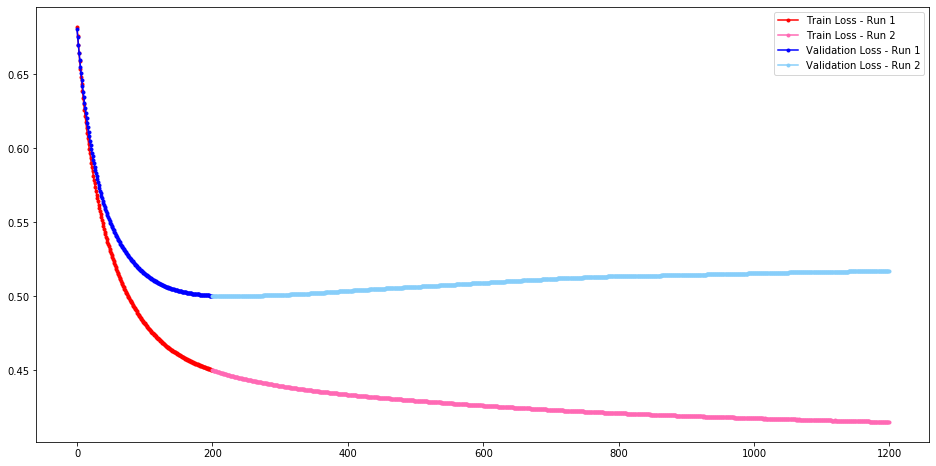

In [25]:
n = len(run_hist_1.history["loss"])
m = len(run_hist_1b.history['loss'])
fig, ax = plt.subplots(figsize=(16, 8))

ax.plot(range(n), run_hist_1.history["loss"],'r', marker='.', label="Train Loss - Run 1")
ax.plot(range(n, n+m), run_hist_1b.history["loss"], 'hotpink', marker='.', label="Train Loss - Run 2")

ax.plot(range(n), run_hist_1.history["val_loss"],'b', marker='.', label="Validation Loss - Run 1")
ax.plot(range(n, n+m), run_hist_1b.history["val_loss"], 'LightSkyBlue', marker='.',  label="Validation Loss - Run 2")

ax.legend()